# Imports

In [1]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

from pathlib import Path

from keras.models import Model
import tensorflow as tf
from keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization


# Select model

In [2]:
### We are using model in the model_0.py file. Change this to load other models.
#from model_3_1a_vs import model
###================================================================================================
# Specify model name to save model as. eg., "model_0", "model_1", "model_2"
MODEL_NAME = 'model_0'

# Plotting functions

In [3]:
###================================================================================================
### Plotting function
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

def plot_Acc_And_Loss2(history_dict, save=True):
    """
    Plots loss and accuracy of train and val data over epochs.
    :return:
    """
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(history_dict['accuracy'])
    axs[0].plot(history_dict['val_accuracy'])
    axs[0].set_title('training vs validation accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    axs[0].grid(True)

    axs[1].plot(history_dict['loss'])
    axs[1].plot(history_dict['val_loss'])
    axs[1].set_title('training vs validation loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    axs[1].grid(True)
    set_size(8,4)
    if save: plt.savefig('model_logs/'+MODEL_NAME+'_logs/'+MODEL_NAME+"_loss.png")
    plt.show()

# Load data and select batch size, epochs.

In [4]:
###================================================================================================
BATCH_SIZE = 32
EPOCHS = 3

### CIFAR10 dataset loading:
### Partition data - data is already partioned from unpacking here:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
input_shape = (32,32,3) # get 1st sample's shape.

# Check shape of each partition. Each img is 32x32x3. 50000 in training set, 10000 in test set.
print("x_train shape = " + str(np.shape(x_train)))
print("y_train shape = " + str(np.shape(y_train)))
print("x_test shape = " + str(np.shape(x_test)))
print("y_test shape = " + str(np.shape(y_test)))

x_train shape = (50000, 32, 32, 3)
y_train shape = (50000, 1)
x_test shape = (10000, 32, 32, 3)
y_test shape = (10000, 1)


# Define Model

In [5]:
def model(input_shape):
    input = Input(input_shape)

    X = Conv2D(filters=32, kernel_size=(3,3), padding='same')(input)
    X = Conv2D(filters=32, kernel_size=(3,3), padding='same')(X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation(activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(rate=.2)(X)

    X = Conv2D(filters=64, kernel_size=(3,3), padding='same')(X)
    X = Conv2D(filters=64, kernel_size=(3,3), padding='same')(X)
    X = BatchNormalization(axis=3)(X) 
    X = Activation(activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(rate=.2)(X)

    X = Conv2D(filters=128, kernel_size=(3,3), padding='same')(X)
    X = Conv2D(filters=128, kernel_size=(3,3), padding='same')(X)
    X = BatchNormalization(axis=3)(X) 
    X = Activation(activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(rate=.2)(X)

    X = Conv2D(filters=256, kernel_size=(3,3), padding='same')(X)
    X = Conv2D(filters=256, kernel_size=(3,3), padding='same')(X)
    X = BatchNormalization(axis=3)(X) 
    X = Activation(activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(rate=.2)(X)

    X = Flatten()(X)
    X = Dense(units=512, activation='relu')(X)
    X = Dropout(rate=.6)(X)
    X = Dense(units=256, activation='relu')(X)
    X = Dropout(rate=.5)(X)
    X = Dense(units=10, activation='softmax')(X)

    model = Model(inputs=input, outputs=X)
    return model

# Compile model

In [6]:
###================================================================================================
### Compile a model.
model = model(input_shape)
opt = Adam(learning_rate=.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
model.compile(optimizer=opt, loss=loss, metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 64)                196672    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


2022-03-14 23:28:41.667358: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train model

In [7]:
###================================================================================================
### Train and Predict.
model_checkpoint = ModelCheckpoint(filepath='model/'+MODEL_NAME,
                                       verbose=1,
                                       monitor='val_loss',
                                       save_best_only=True)
Path('model_logs/'+MODEL_NAME+'_logs/').mkdir(parents=True)
csv_logger = CSVLogger(filename='model_logs/'+MODEL_NAME+'_logs/'+MODEL_NAME+'_log.csv', separator=',', append=True)
# t0 = len(x_train)//BATCH_SIZE
model_history = model.fit(x=x_train, y=y_train, epochs=EPOCHS, callbacks=[csv_logger, model_checkpoint], validation_data=(x_test, y_test))

Epoch 1/3
1563/1563 [==============================] - ETA: 0s - loss: 5.2586 - accuracy: 0.0993
Epoch 00001: val_loss improved from inf to 2.30515, saving model to model/model_0


2022-03-14 23:28:50.480545: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/model_0/assets
1563/1563 [==============================] - 8s 5ms/step - loss: 5.2586 - accuracy: 0.0993 - val_loss: 2.3051 - val_accuracy: 0.0999
Epoch 2/3
1561/1563 [============================>.] - ETA: 0s - loss: 2.3060 - accuracy: 0.0988
Epoch 00002: val_loss improved from 2.30515 to 2.30415, saving model to model/model_0
INFO:tensorflow:Assets written to: model/model_0/assets
1563/1563 [==============================] - 7s 5ms/step - loss: 2.3060 - accuracy: 0.0988 - val_loss: 2.3041 - val_accuracy: 0.1000
Epoch 3/3
1557/1563 [============================>.] - ETA: 0s - loss: 2.3036 - accuracy: 0.0993
Epoch 00003: val_loss did not improve from 2.30415
1563/1563 [==============================] - 6s 4ms/step - loss: 2.3036 - accuracy: 0.0992 - val_loss: 2.3048 - val_accuracy: 0.1000


# Save and plot

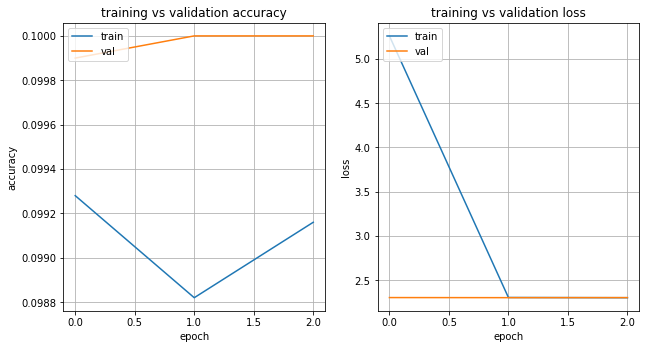

In [8]:
###================================================================================================
"""Save model history and plot loss and acc"""
"""
Note!!! If these files already exist, will get an error. 
"""
with open('model/'+MODEL_NAME+'/trainHistoryDict', 'wb') as file_name:
    pickle.dump(model_history.history, file_name)       # Save history dict
plot_Acc_And_Loss2(model_history.history)        # Plot acc and loss over epochs
with open('model_logs/'+MODEL_NAME+'_logs/'+MODEL_NAME+'_summary', 'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

# Load model
Note: Skip the Compile, Train, Save and Plot if you want to load a saved model.

In [9]:
#model = load_model("model/model_1_vs")

# Predict  


In [10]:
###================================================================================================
### Evaluate model.
print("\nEvaluating model...\n")
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

pred_outs = model.predict(x_test)

pred_labels = np.argmax(pred_outs,axis=1)


Evaluating model...

313/313 - 0s - loss: 2.3048 - accuracy: 0.1000 - 351ms/epoch - 1ms/step


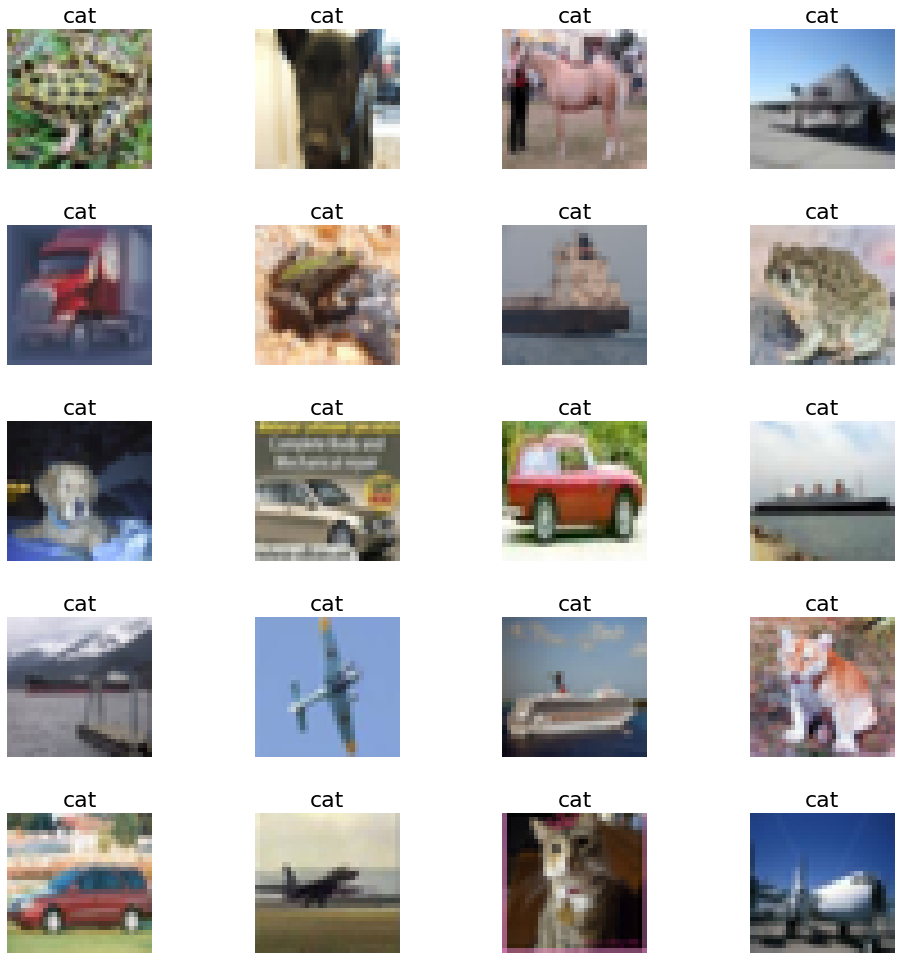

In [14]:
###================================================================================================
# Plotting code
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

W_grid = 4
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

# n_train = len(x_train) # get the length of the train dataset
n_train = len(x_test) # get the length of the test dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 
    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    # axes[i].imshow(x_train[index,1:])
    axes[i].imshow(x_test[index,1:])
    # label_index = int(y_train[index])
    label_index = int(pred_labels[index])
    axes[i].set_title(labels[label_index], fontsize = 22)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

# Performnance Analysis

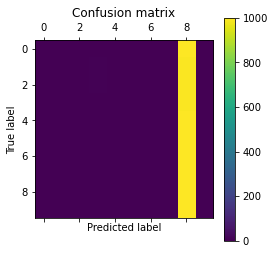

In [ ]:
mat = confusion_matrix(y_test, pred_labels)
plt.matshow(mat)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.colorbar()
plt.show()

In [ ]:
print(classification_report(y_test, pred_labels))
print("Accuracy score " + str(accuracy_score(y_test, pred_labels)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.50      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.16      0.00      0.01      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.10      1.00      0.18      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.08      0.10      0.02     10000
weighted avg       0.08      0.10      0.02     10000

Accuracy score 0.1002


/Users/vishi4_mbp/opt/anaconda3/envs/A1_ECPS211/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vishi4_mbp/opt/anaconda3/envs/A1_ECPS211/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vishi4_mbp/opt/anaconda3/envs/A1_ECPS211/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf